In [1]:
import zipfile
import io
import pandas as pd
import tensorflow as tf
import numpy as np
from tcn_sequence_models.data_processing.preprocessor import Preprocessor
from tcn_sequence_models.models import TCN_TCN_Attention
import matplotlib.pyplot as plt
tf.config.run_functions_eagerly(True)


c:\Users\ssen\.conda\envs\Satellite\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\ssen\.conda\envs\Satellite\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\ssen\.conda\envs\Satellite\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
c:\Users\ssen\.conda\envs\Satellite\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [2]:
import numpy as np

def compute_score(y_pred, y_true):
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    dn = y_pred - y_true
    score_negative = np.sum(np.exp(-dn[dn < 0] / 13) - 1)
    score_nonnegative = np.sum(np.exp(dn[dn >= 0] / 10) - 1)
    return score_negative + score_nonnegative

In [3]:
#test FD001

input_file = "C:\\Users\\ssen\\Documents\\RUL\\RULprediction\\processed_data_test_FD001_all.zip"
config_path = "C:\\Users\\ssen\\Documents\\RUL\\RULprediction\\EngineHealthPred\\ModelWeights\\RULFD001_2"
model = TCN_TCN_Attention()
with zipfile.ZipFile(input_file, 'r') as zip_ref:
    file_list = zip_ref.namelist()

    input_seq_len = 15
    output_seq_len = 1
    features_input_encoder = ['sensor_measurement_2','sensor_measurement_3','sensor_measurement_4','sensor_measurement_7','sensor_measurement_8','sensor_measurement_9','sensor_measurement_11','sensor_measurement_12','sensor_measurement_13','sensor_measurement_14','sensor_measurement_15','sensor_measurement_17','sensor_measurement_20','sensor_measurement_21']  #,'delta_sensor_measurement_2','delta_sensor_measurement_3','delta_sensor_measurement_4','delta_sensor_measurement_7','delta_sensor_measurement_8','delta_sensor_measurement_9','delta_sensor_measurement_11','delta_sensor_measurement_12','delta_sensor_measurement_13','delta_sensor_measurement_14','delta_sensor_measurement_15','delta_sensor_measurement_17','delta_sensor_measurement_20','delta_sensor_measurement_21']
    features_input_decoder = ['sensor_measurement_2','sensor_measurement_3','sensor_measurement_4','sensor_measurement_7','sensor_measurement_8','sensor_measurement_9','sensor_measurement_11','sensor_measurement_12','sensor_measurement_13','sensor_measurement_14','sensor_measurement_15','sensor_measurement_17','sensor_measurement_20','sensor_measurement_21']  #,'delta_sensor_measurement_2','delta_sensor_measurement_3','delta_sensor_measurement_4','delta_sensor_measurement_7','delta_sensor_measurement_8','delta_sensor_measurement_9','delta_sensor_measurement_11','delta_sensor_measurement_12','delta_sensor_measurement_13','delta_sensor_measurement_14','delta_sensor_measurement_15','delta_sensor_measurement_17','delta_sensor_measurement_20','delta_sensor_measurement_21']
    feature_target = ['RUL']

    y_predicted_1 = []
    y_real_1 = []

    for file_name in file_list:
        with zip_ref.open(file_name) as file:
            df = pd.read_csv(io.TextIOWrapper(file))
            df.set_index('time_cycles', inplace=True)
            df.fillna(0, inplace=True)
            preprocessor = Preprocessor(df)
            preprocessor.process(
                features_input_encoder,
                features_input_decoder,
                feature_target,
                input_seq_len,
                output_seq_len,
                model_type="tcn_tcn",
                time_col=df.index,
                split_ratio=0.8,
                split_date=None,
                temporal_encoding_modes=None,
                autoregressive=False
            )
            X, y = preprocessor.train_split()
            # print(X[0].shape)
            model.load_model(config_path, X, is_training_data=False)
            y_pred = model.predict(X)
            y_real_1.append(y[-1:])
            y_predicted_1.append(y_pred[-1:])

print(y_predicted_1)
print(y_real_1)
            # print(y_pred[-1:])
            # print('xxx')
            # print(y[-1:])
            # print('XXXXXXXXXXXX')
            # break


6/6 [==============================] - 1s 14ms/step
[array([[[43.770844]]], dtype=float32), array([[[40.827694]]], dtype=float32), array([[[19.463402]]], dtype=float32), array([[[27.06616]]], dtype=float32), array([[[26.430164]]], dtype=float32), array([[[34.97874]]], dtype=float32), array([[[24.91061]]], dtype=float32), array([[[17.55875]]], dtype=float32), array([[[86.52497]]], dtype=float32), array([[[18.160095]]], dtype=float32), array([[[19.846392]]], dtype=float32), array([[[22.255276]]], dtype=float32), array([[[19.730759]]], dtype=float32), array([[[53.146313]]], dtype=float32), array([[[55.79028]]], dtype=float32), array([[[21.484175]]], dtype=float32), array([[[16.337284]]], dtype=float32), array([[[16.901943]]], dtype=float32), array([[[28.920013]]], dtype=float32), array([[[9.952]]], dtype=float32), array([[[83.93068]]], dtype=float32), array([[[73.13375]]], dtype=float32), array([[[30.605904]]], dtype=float32), array([[[16.131622]]], dtype=float32), array([[[109.380775]]],

RMSE: 50.605191080359255
Computed score: 23666.337164456756


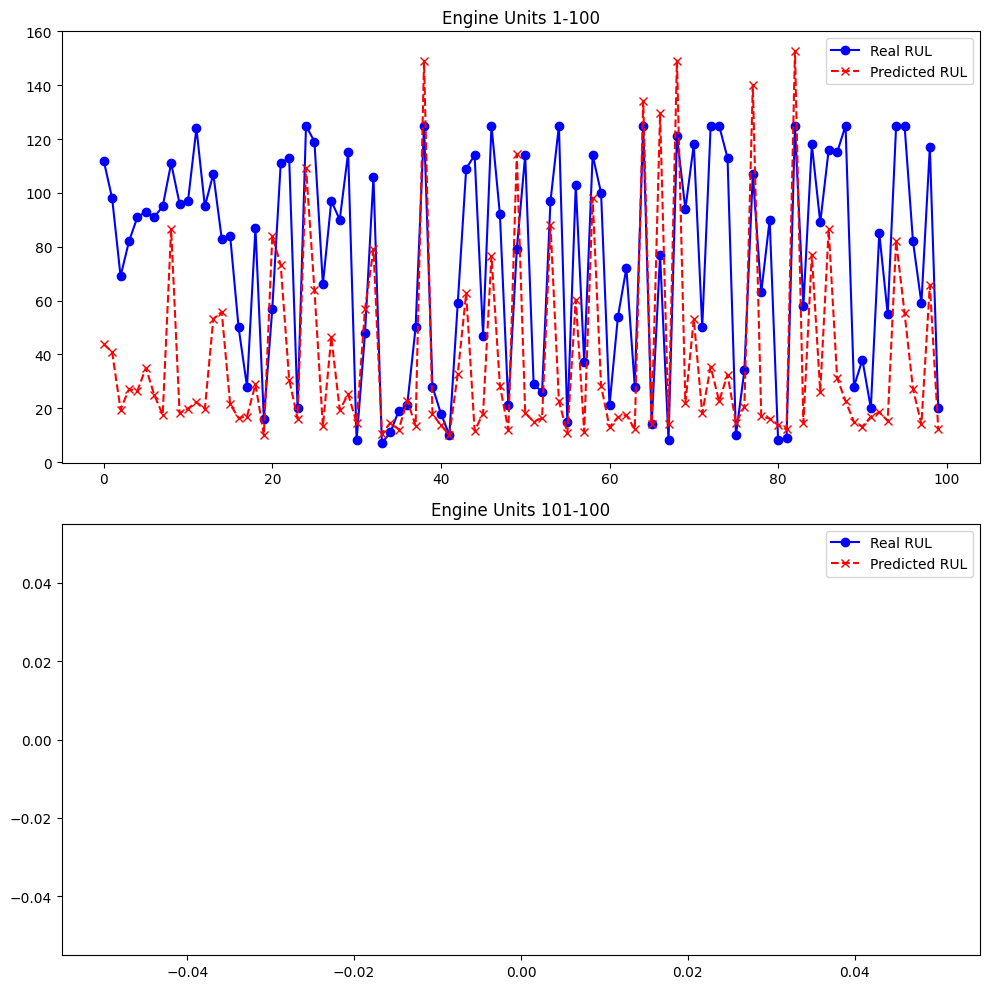

In [5]:
from sklearn.metrics import mean_squared_error
import numpy as np
y_predicted_1 = np.array(y_predicted_1).reshape(-1)
y_real_1 = np.array(y_real_1).reshape(-1)
rmse = np.sqrt(mean_squared_error(y_real_1, y_predicted_1))
print("RMSE:", rmse)

score = compute_score(y_predicted_1, y_real_1)
print("Computed score:", score)
num_units = len(y_real_1)
num_plots = num_units // 100 + 1

fig, axs = plt.subplots(num_plots, figsize=(10, 5*num_plots))

for i in range(num_plots):
    start_index = i * 100
    end_index = min((i + 1) * 100, num_units)
    
    y_real_unit = np.array(y_real_1[start_index:end_index]).flatten()
    y_predicted_unit = np.array(y_predicted_1[start_index:end_index]).flatten()
    
    axs[i].plot(y_real_unit, label='Real RUL', marker='o', color='blue', linestyle='-')
    axs[i].plot(y_predicted_unit, label='Predicted RUL', marker='x', color='red', linestyle='--')
    axs[i].set_title(f"Engine Units {start_index + 1}-{end_index}")
    axs[i].legend()

plt.tight_layout()
plt.show()


In [ ]:
#Test individula unit

input_file = "C:\\Users\\ssen\\Documents\\RUL\\RULprediction\\processed_data_test_FD001_all\\unit_100_1_processed.csv"
config_path = "C:\\Users\\ssen\\Documents\\RUL\\RULprediction\\EngineHealthPred\\ModelWeights\\RULFD001_2"
model = TCN_TCN_Attention()
# with zipfile.ZipFile(input_file, 'r') as zip_ref:
#     file_list = zip_ref.namelist()

input_seq_len = 15
output_seq_len = 1
features_input_encoder = ['sensor_measurement_2','sensor_measurement_3','sensor_measurement_4','sensor_measurement_7','sensor_measurement_8','sensor_measurement_9','sensor_measurement_11','sensor_measurement_12','sensor_measurement_13','sensor_measurement_14','sensor_measurement_15','sensor_measurement_17','sensor_measurement_20','sensor_measurement_21']  #,'delta_sensor_measurement_2','delta_sensor_measurement_3','delta_sensor_measurement_4','delta_sensor_measurement_7','delta_sensor_measurement_8','delta_sensor_measurement_9','delta_sensor_measurement_11','delta_sensor_measurement_12','delta_sensor_measurement_13','delta_sensor_measurement_14','delta_sensor_measurement_15','delta_sensor_measurement_17','delta_sensor_measurement_20','delta_sensor_measurement_21']
features_input_decoder = ['sensor_measurement_2','sensor_measurement_3','sensor_measurement_4','sensor_measurement_7','sensor_measurement_8','sensor_measurement_9','sensor_measurement_11','sensor_measurement_12','sensor_measurement_13','sensor_measurement_14','sensor_measurement_15','sensor_measurement_17','sensor_measurement_20','sensor_measurement_21']  #,'delta_sensor_measurement_2','delta_sensor_measurement_3','delta_sensor_measurement_4','delta_sensor_measurement_7','delta_sensor_measurement_8','delta_sensor_measurement_9','delta_sensor_measurement_11','delta_sensor_measurement_12','delta_sensor_measurement_13','delta_sensor_measurement_14','delta_sensor_measurement_15','delta_sensor_measurement_17','delta_sensor_measurement_20','delta_sensor_measurement_21']
feature_target = ['RUL']

y_predicted_1 = []
y_real_1 = []

    # for file_name in file_list:
    #     with zip_ref.open(file_name) as file:
df = pd.read_csv(io.TextIOWrapper(input_file))
df.set_index('time_cycles', inplace=True)
df.fillna(0, inplace=True)
preprocessor = Preprocessor(df)
preprocessor.process(
    features_input_encoder,
    features_input_decoder,
    feature_target,
    input_seq_len,
    output_seq_len,
    model_type="tcn_tcn",
    time_col=df.index,
    split_ratio=0.8,
    split_date=None,
    temporal_encoding_modes=None,
    autoregressive=False
)
X, y = preprocessor.train_split()
# print(X[0].shape)
model.load_model(config_path, X, is_training_data=False)
y_pred = model.predict(X)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(y, label='True RUL')
ax.plot(y_pred, label='Predicted RUL')

ax.set_xlabel('Time')
ax.set_ylabel('RUL')
ax.set_title('True vs Predicted RUL for Test Unit 100')
ax.legend()
plt.show()

    

#             y_real_1.append(y[-1:])
#             y_predicted_1.append(y_pred[-1:])

# print(y_predicted_1)
# print(y_real_1)

In [7]:
#testFD002
input_file = "C:\\Users\\ssen\\Documents\\RUL\\RULprediction\\processed_data_test_FD002_all.zip"
config_path = "C:\\Users\\ssen\\Documents\\RUL\\RULprediction\\EngineHealthPred\\ModelWeights\\RUL2"
model = TCN_TCN_Attention()
with zipfile.ZipFile(input_file, 'r') as zip_ref:
    file_list = zip_ref.namelist()

    input_seq_len = 15
    output_seq_len = 1
    features_input_encoder = ['operational_setting_1','operational_setting_2','operational_setting_3','sensor_measurement_2','sensor_measurement_3','sensor_measurement_4','sensor_measurement_7','sensor_measurement_8','sensor_measurement_9','sensor_measurement_11','sensor_measurement_12','sensor_measurement_13','sensor_measurement_14','sensor_measurement_15','sensor_measurement_17','sensor_measurement_20','sensor_measurement_21','delta_sensor_measurement_2','delta_sensor_measurement_3','delta_sensor_measurement_4','delta_sensor_measurement_7','delta_sensor_measurement_8','delta_sensor_measurement_9','delta_sensor_measurement_11','delta_sensor_measurement_12','delta_sensor_measurement_13','delta_sensor_measurement_14','delta_sensor_measurement_15','delta_sensor_measurement_17','delta_sensor_measurement_20','delta_sensor_measurement_21']
    features_input_decoder = ['operational_setting_1','operational_setting_2','operational_setting_3','sensor_measurement_2','sensor_measurement_3','sensor_measurement_4','sensor_measurement_7','sensor_measurement_8','sensor_measurement_9','sensor_measurement_11','sensor_measurement_12','sensor_measurement_13','sensor_measurement_14','sensor_measurement_15','sensor_measurement_17','sensor_measurement_20','sensor_measurement_21','delta_sensor_measurement_2','delta_sensor_measurement_3','delta_sensor_measurement_4','delta_sensor_measurement_7','delta_sensor_measurement_8','delta_sensor_measurement_9','delta_sensor_measurement_11','delta_sensor_measurement_12','delta_sensor_measurement_13','delta_sensor_measurement_14','delta_sensor_measurement_15','delta_sensor_measurement_17','delta_sensor_measurement_20','delta_sensor_measurement_21']
    feature_target = ['RUL']

    y_predicted = []
    y_real = []

    for file_name in file_list:
        with zip_ref.open(file_name) as file:
            df = pd.read_csv(io.TextIOWrapper(file))
            df.set_index('time_cycles', inplace=True)
            df.fillna(0, inplace=True)
            preprocessor = Preprocessor(df)
            preprocessor.process(
                features_input_encoder,
                features_input_decoder,
                feature_target,
                input_seq_len,
                output_seq_len,
                model_type="tcn_tcn",
                time_col=df.index,
                split_ratio=0.8,
                split_date=None,
                temporal_encoding_modes=None,
                autoregressive=False
            )
            X, y = preprocessor.train_split()
            # print(X[0].shape)
            model.load_model(config_path, X, is_training_data=False)
            y_pred = model.predict(X)
            y_real.append(y[-1:])
            y_predicted.append(y_pred[-1:])

print(y_predicted)
print(y_real)

4/4 [==============================] - 0s 4ms/step
[array([[[19.715187]]], dtype=float32), array([[[25.12955]]], dtype=float32), array([[[51.749046]]], dtype=float32), array([[[54.55358]]], dtype=float32), array([[[5.1548014]]], dtype=float32), array([[[91.64586]]], dtype=float32), array([[[36.73588]]], dtype=float32), array([[[57.58362]]], dtype=float32), array([[[6.7032337]]], dtype=float32), array([[[37.043]]], dtype=float32), array([[[4.759513]]], dtype=float32), array([[[76.036316]]], dtype=float32), array([[[18.026106]]], dtype=float32), array([[[26.620955]]], dtype=float32), array([[[23.480186]]], dtype=float32), array([[[19.693771]]], dtype=float32), array([[[21.59714]]], dtype=float32), array([[[42.53664]]], dtype=float32), array([[[48.141113]]], dtype=float32), array([[[62.11857]]], dtype=float32), array([[[52.17392]]], dtype=float32), array([[[8.124368]]], dtype=float32), array([[[107.62579]]], dtype=float32), array([[[16.575062]]], dtype=float32), array([[[32.51918]]], dtyp

In [6]:
y_predicted = np.array(y_predicted).reshape(-1)
y_real = np.array(y_real).reshape(-1)
rmse = np.sqrt(mean_squared_error(y_real, y_predicted))
print("RMSE:", rmse)

score = compute_score(y_predicted, y_real)
print("Computed score:", score)
num_units = len(y_real)
num_plots = num_units // 100 + 1

fig, axs = plt.subplots(num_plots, figsize=(10, 5*num_plots))

for i in range(num_plots):
    start_index = i * 100
    end_index = min((i + 1) * 100, num_units)
    
    y_real_unit = np.array(y_real[start_index:end_index]).flatten()
    y_predicted_unit = np.array(y_predicted[start_index:end_index]).flatten()
    
    axs[i].plot(y_real_unit, label='Real RUL')
    axs[i].plot(y_predicted_unit, label='Predicted RUL')
    axs[i].set_title(f"Engine Units {start_index + 1}-{end_index}")
    axs[i].legend()

plt.tight_layout()
plt.show()

NameError: name 'y_predicted' is not defined

In [9]:
#testFD003
input_file = "C:\\Users\\ssen\\Documents\\RUL\\RULprediction\\processed_data_test_FD003_all.zip"
config_path = "C:\\Users\\ssen\\Documents\\RUL\\RULprediction\\EngineHealthPred\\ModelWeights\\RUL2"
model = TCN_TCN_Attention()
with zipfile.ZipFile(input_file, 'r') as zip_ref:
    file_list = zip_ref.namelist()

    input_seq_len = 15
    output_seq_len = 1
    features_input_encoder = ['operational_setting_1','operational_setting_2','operational_setting_3','sensor_measurement_2','sensor_measurement_3','sensor_measurement_4','sensor_measurement_7','sensor_measurement_8','sensor_measurement_9','sensor_measurement_11','sensor_measurement_12','sensor_measurement_13','sensor_measurement_14','sensor_measurement_15','sensor_measurement_17','sensor_measurement_20','sensor_measurement_21','delta_sensor_measurement_2','delta_sensor_measurement_3','delta_sensor_measurement_4','delta_sensor_measurement_7','delta_sensor_measurement_8','delta_sensor_measurement_9','delta_sensor_measurement_11','delta_sensor_measurement_12','delta_sensor_measurement_13','delta_sensor_measurement_14','delta_sensor_measurement_15','delta_sensor_measurement_17','delta_sensor_measurement_20','delta_sensor_measurement_21']
    features_input_decoder = ['operational_setting_1','operational_setting_2','operational_setting_3','sensor_measurement_2','sensor_measurement_3','sensor_measurement_4','sensor_measurement_7','sensor_measurement_8','sensor_measurement_9','sensor_measurement_11','sensor_measurement_12','sensor_measurement_13','sensor_measurement_14','sensor_measurement_15','sensor_measurement_17','sensor_measurement_20','sensor_measurement_21','delta_sensor_measurement_2','delta_sensor_measurement_3','delta_sensor_measurement_4','delta_sensor_measurement_7','delta_sensor_measurement_8','delta_sensor_measurement_9','delta_sensor_measurement_11','delta_sensor_measurement_12','delta_sensor_measurement_13','delta_sensor_measurement_14','delta_sensor_measurement_15','delta_sensor_measurement_17','delta_sensor_measurement_20','delta_sensor_measurement_21']
    feature_target = ['RUL']

    y_predicted = []
    y_real = []

    for file_name in file_list:
        with zip_ref.open(file_name) as file:
            df = pd.read_csv(io.TextIOWrapper(file))
            df.set_index('time_cycles', inplace=True)
            df.fillna(0, inplace=True)
            preprocessor = Preprocessor(df)
            preprocessor.process(
                features_input_encoder,
                features_input_decoder,
                feature_target,
                input_seq_len,
                output_seq_len,
                model_type="tcn_tcn",
                time_col=df.index,
                split_ratio=0.8,
                split_date=None,
                temporal_encoding_modes=None,
                autoregressive=False
            )
            X, y = preprocessor.train_split()
            # print(X[0].shape)
            model.load_model(config_path, X, is_training_data=False)
            y_pred = model.predict(X)
            y_real.append(y[-1:])
            y_predicted.append(y_pred[-1:])

print(y_predicted)
print(y_real)

8/8 [==============================] - 0s 3ms/step
[array([[[47.715282]]], dtype=float32), array([[[4.815566]]], dtype=float32), array([[[11.6918955]]], dtype=float32), array([[[67.48147]]], dtype=float32), array([[[119.7794]]], dtype=float32), array([[[7.314743]]], dtype=float32), array([[[12.043033]]], dtype=float32), array([[[3.3008695]]], dtype=float32), array([[[7.5519285]]], dtype=float32), array([[[10.511185]]], dtype=float32), array([[[51.314404]]], dtype=float32), array([[[16.846878]]], dtype=float32), array([[[25.542988]]], dtype=float32), array([[[6.556733]]], dtype=float32), array([[[83.3409]]], dtype=float32), array([[[96.93044]]], dtype=float32), array([[[17.534845]]], dtype=float32), array([[[185.79399]]], dtype=float32), array([[[7.321148]]], dtype=float32), array([[[81.6832]]], dtype=float32), array([[[48.939087]]], dtype=float32), array([[[66.656006]]], dtype=float32), array([[[28.371355]]], dtype=float32), array([[[20.420448]]], dtype=float32), array([[[11.7811985]]]

RMSE: 55.99468484643838
Computed score: 15363634.195576424


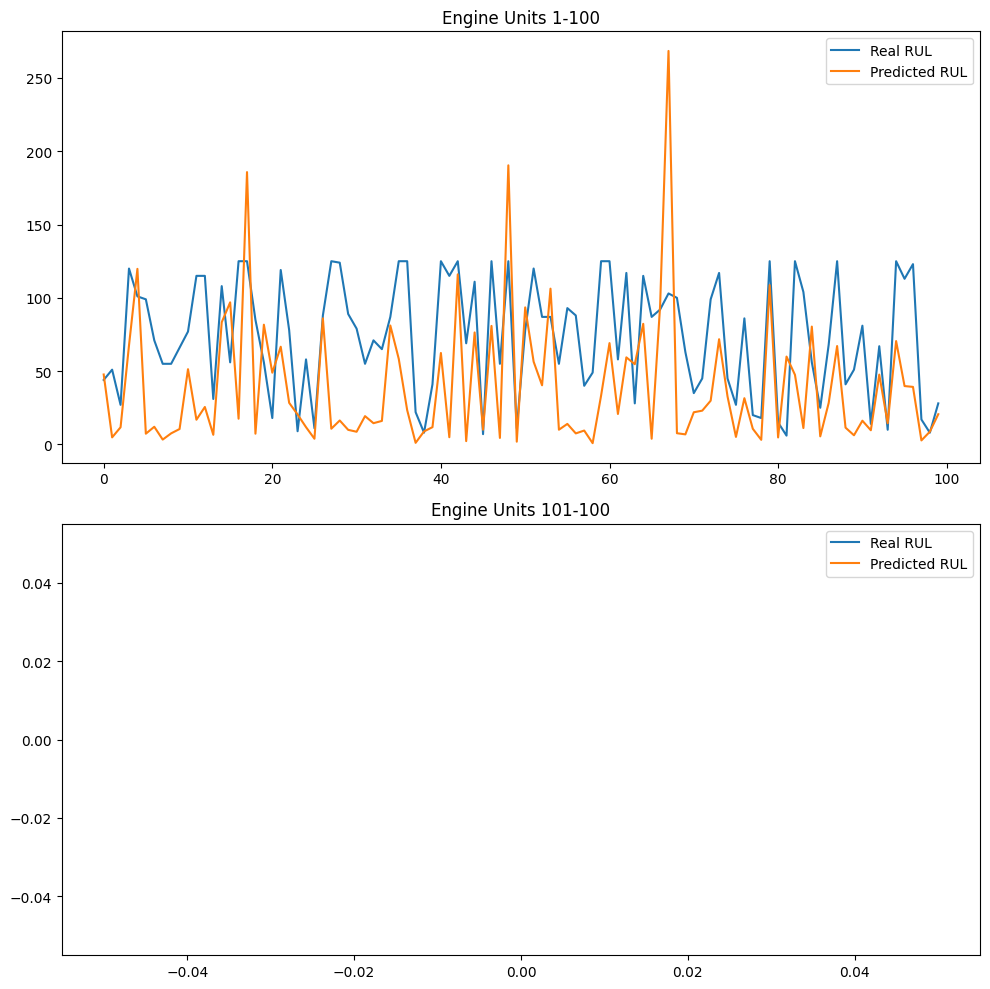

In [11]:
y_predicted = np.array(y_predicted).reshape(-1)
y_real = np.array(y_real).reshape(-1)
rmse = np.sqrt(mean_squared_error(y_real, y_predicted))
print("RMSE:", rmse)

score = compute_score(y_predicted, y_real)
print("Computed score:", score)
num_units = len(y_real)
num_plots = num_units // 100 + 1

fig, axs = plt.subplots(num_plots, figsize=(10, 5*num_plots))

for i in range(num_plots):
    start_index = i * 100
    end_index = min((i + 1) * 100, num_units)
    
    y_real_unit = np.array(y_real[start_index:end_index]).flatten()
    y_predicted_unit = np.array(y_predicted[start_index:end_index]).flatten()
    
    axs[i].plot(y_real_unit, label='Real RUL')
    axs[i].plot(y_predicted_unit, label='Predicted RUL')
    axs[i].set_title(f"Engine Units {start_index + 1}-{end_index}")
    axs[i].legend()

plt.tight_layout()
plt.show()

In [12]:
#testFD004
input_file = "C:\\Users\\ssen\\Documents\\RUL\\RULprediction\\processed_data_test_FD004_all.zip"
config_path = "C:\\Users\\ssen\\Documents\\RUL\\RULprediction\\EngineHealthPred\\ModelWeights\\RUL2"
model = TCN_TCN_Attention()
with zipfile.ZipFile(input_file, 'r') as zip_ref:
    file_list = zip_ref.namelist()

    input_seq_len = 15
    output_seq_len = 1
    features_input_encoder = ['operational_setting_1','operational_setting_2','operational_setting_3','sensor_measurement_2','sensor_measurement_3','sensor_measurement_4','sensor_measurement_7','sensor_measurement_8','sensor_measurement_9','sensor_measurement_11','sensor_measurement_12','sensor_measurement_13','sensor_measurement_14','sensor_measurement_15','sensor_measurement_17','sensor_measurement_20','sensor_measurement_21','delta_sensor_measurement_2','delta_sensor_measurement_3','delta_sensor_measurement_4','delta_sensor_measurement_7','delta_sensor_measurement_8','delta_sensor_measurement_9','delta_sensor_measurement_11','delta_sensor_measurement_12','delta_sensor_measurement_13','delta_sensor_measurement_14','delta_sensor_measurement_15','delta_sensor_measurement_17','delta_sensor_measurement_20','delta_sensor_measurement_21']
    features_input_decoder = ['operational_setting_1','operational_setting_2','operational_setting_3','sensor_measurement_2','sensor_measurement_3','sensor_measurement_4','sensor_measurement_7','sensor_measurement_8','sensor_measurement_9','sensor_measurement_11','sensor_measurement_12','sensor_measurement_13','sensor_measurement_14','sensor_measurement_15','sensor_measurement_17','sensor_measurement_20','sensor_measurement_21','delta_sensor_measurement_2','delta_sensor_measurement_3','delta_sensor_measurement_4','delta_sensor_measurement_7','delta_sensor_measurement_8','delta_sensor_measurement_9','delta_sensor_measurement_11','delta_sensor_measurement_12','delta_sensor_measurement_13','delta_sensor_measurement_14','delta_sensor_measurement_15','delta_sensor_measurement_17','delta_sensor_measurement_20','delta_sensor_measurement_21']
    feature_target = ['RUL']

    y_predicted = []
    y_real = []

    for file_name in file_list:
        with zip_ref.open(file_name) as file:
            df = pd.read_csv(io.TextIOWrapper(file))
            df.set_index('time_cycles', inplace=True)
            df.fillna(0, inplace=True)
            preprocessor = Preprocessor(df)
            preprocessor.process(
                features_input_encoder,
                features_input_decoder,
                feature_target,
                input_seq_len,
                output_seq_len,
                model_type="tcn_tcn",
                time_col=df.index,
                split_ratio=0.8,
                split_date=None,
                temporal_encoding_modes=None,
                autoregressive=False
            )
            X, y = preprocessor.train_split()
            # print(X[0].shape)
            model.load_model(config_path, X, is_training_data=False)
            y_pred = model.predict(X)
            y_real.append(y[-1:])
            y_predicted.append(y_pred[-1:])

print(y_predicted)
print(y_real)

9/9 [==============================] - 0s 4ms/step
[array([[[18.717289]]], dtype=float32), array([[[41.63437]]], dtype=float32), array([[[83.82648]]], dtype=float32), array([[[62.83892]]], dtype=float32), array([[[86.01014]]], dtype=float32), array([[[31.64859]]], dtype=float32), array([[[84.235466]]], dtype=float32), array([[[20.786362]]], dtype=float32), array([[[22.471416]]], dtype=float32), array([[[5.97315]]], dtype=float32), array([[[65.224045]]], dtype=float32), array([[[7.755898]]], dtype=float32), array([[[83.13388]]], dtype=float32), array([[[38.338783]]], dtype=float32), array([[[17.003204]]], dtype=float32), array([[[109.676506]]], dtype=float32), array([[[69.043045]]], dtype=float32), array([[[36.12288]]], dtype=float32), array([[[40.848263]]], dtype=float32), array([[[45.728477]]], dtype=float32), array([[[63.695263]]], dtype=float32), array([[[9.017101]]], dtype=float32), array([[[17.177258]]], dtype=float32), array([[[66.24205]]], dtype=float32), array([[[78.66487]]], d

RMSE: 44.389472781410674
Computed score: 43138.17931721878


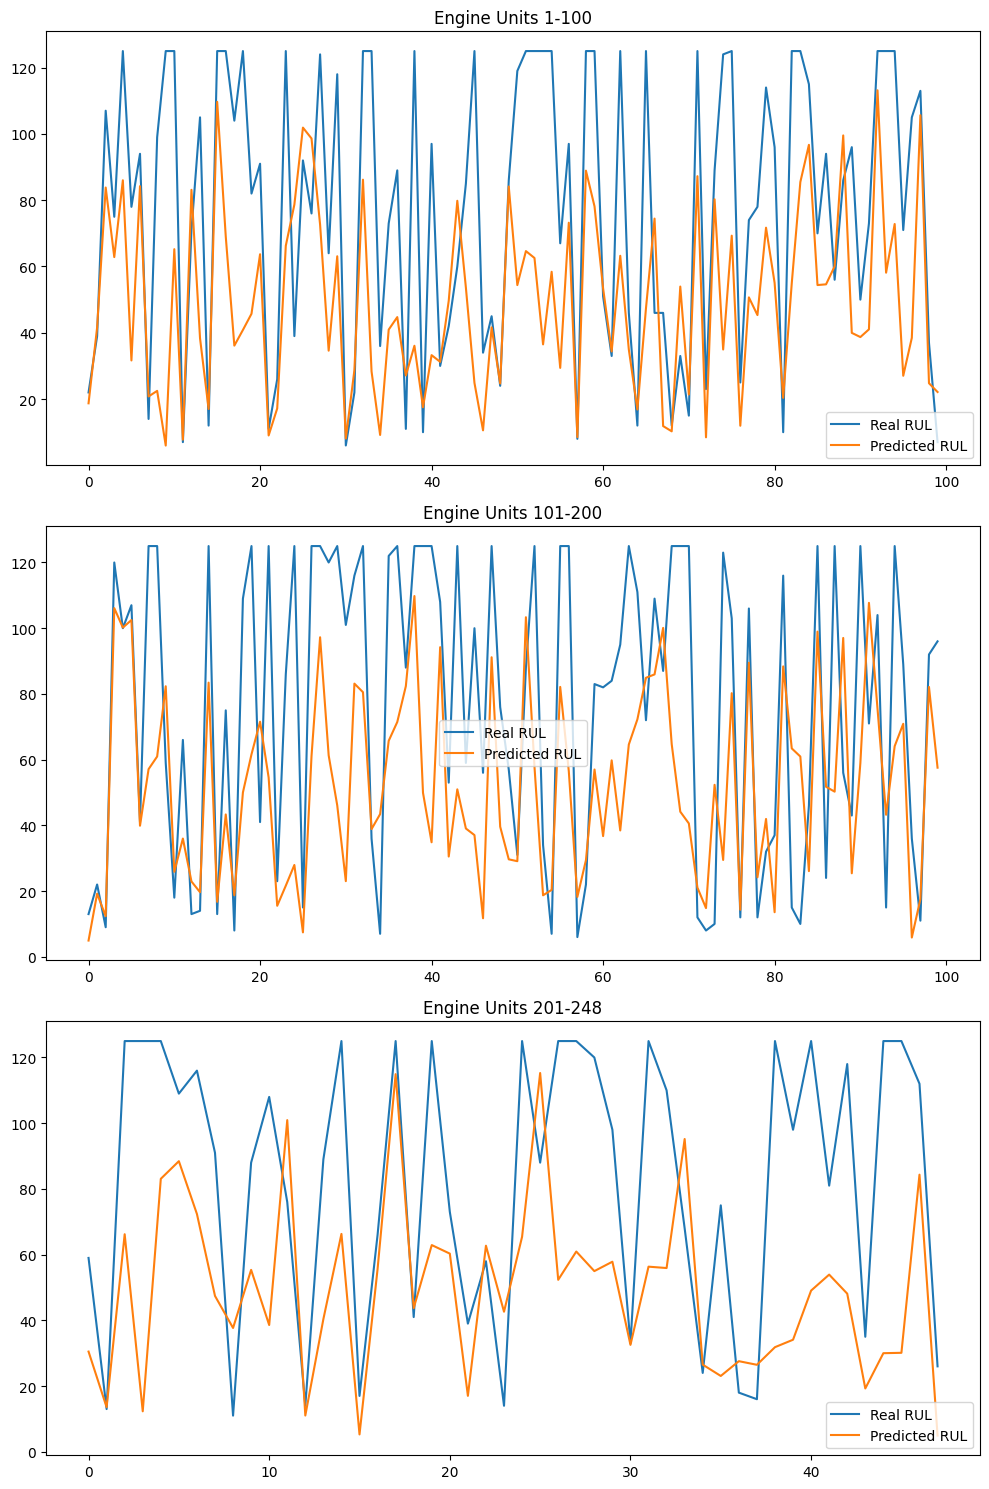

In [13]:
y_predicted = np.array(y_predicted).reshape(-1)
y_real = np.array(y_real).reshape(-1)
rmse = np.sqrt(mean_squared_error(y_real, y_predicted))
print("RMSE:", rmse)

score = compute_score(y_predicted, y_real)
print("Computed score:", score)
num_units = len(y_real)
num_plots = num_units // 100 + 1

fig, axs = plt.subplots(num_plots, figsize=(10, 5*num_plots))

for i in range(num_plots):
    start_index = i * 100
    end_index = min((i + 1) * 100, num_units)
    
    y_real_unit = np.array(y_real[start_index:end_index]).flatten()
    y_predicted_unit = np.array(y_predicted[start_index:end_index]).flatten()
    
    axs[i].plot(y_real_unit, label='Real RUL')
    axs[i].plot(y_predicted_unit, label='Predicted RUL')
    axs[i].set_title(f"Engine Units {start_index + 1}-{end_index}")
    axs[i].legend()

plt.tight_layout()
plt.show()